In [1]:
import keras
from src.ParticleNet.EdgeConvLayer import EdgeConvLayer
from src.ParticleNet.GlobalPooling import GlobalAveragePoolingLayer
from utilities import utilities
from ML.ParticleCloud.data_loaders import load_data_top_tagging

#### Loading the Data

In [2]:
X_train, y_train = load_data_top_tagging(top_quark_path="../../../Data/Trainning/t_jets.csv", quark_data_path="../../../Data/Trainning/q_jets.csv", gluon_data_path="../../../Data/Trainning/g_jets.csv")
X_val, y_val = load_data_top_tagging(top_quark_path="../../../Data/Validation/t_jets.csv",quark_data_path="../../../Data/Validation/q_jets.csv", gluon_data_path="../../../Data/Validation/g_jets.csv")

In [3]:
print(f"Size of the Training set: {len(X_train)}")
print(f"Size of the Validation set: {len(X_val)}")

Size of the Training set: 254254
Size of the Validation set: 44869


In [4]:
X_train.shape

(254254, 30, 5)

#### Setting up the NN

In [13]:
# MLP for the first conv layer
mlp_jets = keras.Sequential([
    keras.layers.InputLayer(shape=[8]),
    keras.layers.Dense(16),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(16),
    keras.layers.LeakyReLU()
])

mlp_jets_2 = keras.Sequential([
    keras.layers.InputLayer(shape=[40]),
    keras.layers.Dense(32),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(32),
    keras.layers.LeakyReLU()
])


# MLP for the second convolutional layer
jet_tag_model = keras.Sequential([
    keras.layers.InputLayer(shape=(30, 5)),
    EdgeConvLayer(mlp=mlp_jets, n_particles_features=4, mlp_output_dim=16, final_index_coord=2, max_number_particles=30, k_neighbors=4),
    EdgeConvLayer(mlp=mlp_jets_2, n_particles_features=20, mlp_output_dim=32, final_index_coord=20, max_number_particles=30, k_neighbors=4),
    GlobalAveragePoolingLayer(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(rate=0.1),
    keras.layers.Dense(2, activation='softmax')
])

jet_tag_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ edge_conv_layer_3               │ (None, 30, 21)         │           416 │
│ (EdgeConvLayer)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ edge_conv_layer_4               │ (None, 30, 53)         │         2,368 │
│ (EdgeConvLayer)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer_2  │ (None, 52)             │             0 │
│ (GlobalAveragePoolingLayer)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         3,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,306 (24.63 KB)

 Trainable params: 6,306 (24.63 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
jet_tag_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', "auc"])

In [15]:
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = jet_tag_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])   

Epoch 1/100
3973/3973 ━━━━━━━━━━━━━━━━━━━━ 93s 23ms/step - accuracy: 0.8336 - auc: 0.9024 - loss: 0.3919 - val_accuracy: 0.8534 - val_auc: 0.9259 - val_loss: 0.3467
Epoch 2/100
3973/3973 ━━━━━━━━━━━━━━━━━━━━ 86s 22ms/step - accuracy: 0.8631 - auc: 0.9317 - loss: 0.3319 - val_accuracy: 0.8706 - val_auc: 0.9389 - val_loss: 0.3158
Epoch 3/100
3973/3973 ━━━━━━━━━━━━━━━━━━━━ 90s 23ms/step - accuracy: 0.8692 - auc: 0.9360 - loss: 0.3216 - val_accuracy: 0.8727 - val_auc: 0.9413 - val_loss: 0.3097
Epoch 4/100
3973/3973 ━━━━━━━━━━━━━━━━━━━━ 91s 23ms/step - accuracy: 0.8723 - auc: 0.9388 - loss: 0.3151 - val_accuracy: 0.8764 - val_auc: 0.9435 - val_loss: 0.3038
Epoch 5/100
3973/3973 ━━━━━━━━━━━━━━━━━━━━ 93s 23ms/step - accuracy: 0.8747 - auc: 0.9415 - loss: 0.3083 - val_accuracy: 0.8761 - val_auc: 0.9460 - val_loss: 0.2990
Epoch 6/100
3973/3973 ━━━━━━━━━━━━━━━━━━━━ 93s 23ms/step - accuracy: 0.8756 - auc: 0.9422 - loss: 0.3065 - val_accuracy: 0.8744 - val_auc: 0.9455 - val_loss: 0.2999
Epoch 7/10

In [16]:
# perfoming the prediction
y_train_pred = jet_tag_model.predict(X_train)
y_val_pred = jet_tag_model.predict(X_val)

7946/7946 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step
1403/1403 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


In [17]:
print("Trainnig set:")
utilities.display_metrics(y_true=y_train[:, 0], y_pred=y_train_pred[:, 0] > 0.5)
print("Validation set:")
utilities.display_metrics(y_true=y_val[:, 0], y_pred=y_val_pred[:, 0] > 0.5)

Trainnig set:
Recall: 0.9108
Precision: 0.8742
Confusion Matrix:
[[108837  16852]
 [ 11472 117093]]
Validation set:
Recall: 0.9077
Precision: 0.8734
Confusion Matrix:
[[19197  2984]
 [ 2093 20595]]


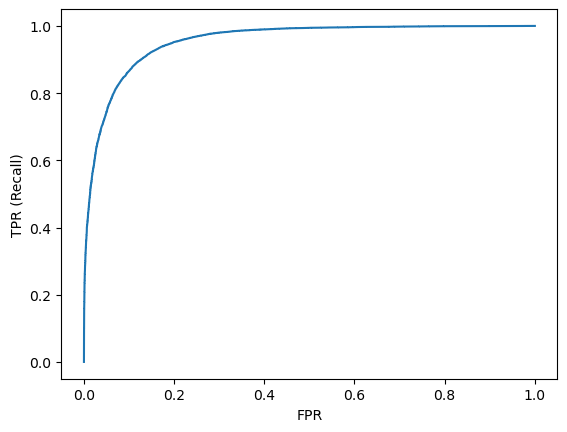

AUC: 0.9549


In [18]:
utilities.display_roc_curve(y_true=y_val[:, 0], y_score=y_val_pred[:, 0])

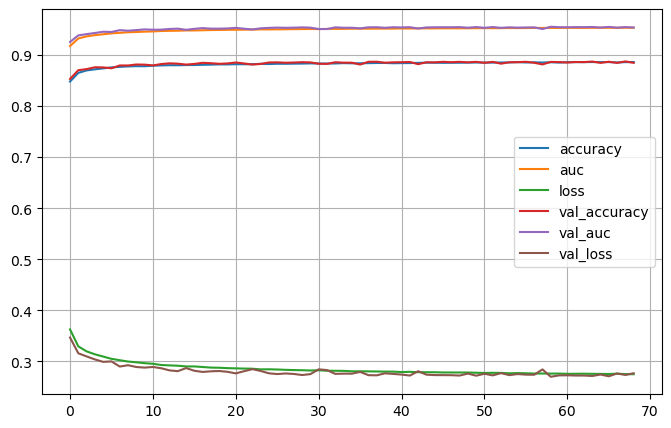

In [19]:
utilities.plot_hist_trainning(history)

In [20]:
utilities.save_model(jet_tag_model, history, "Top_Tagging_ParticleCloud_Final")